In [48]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
#Commented by: James Xi Zheng 12/Aug/2019
#please create functions to do the following jobs
#1. load dataset ->  sample code availalable in the workshops
#2. visualize data -> sample code given
#3. remove signal noises -> sample code given
#4. extract features -> sample code given
#5. prepare training set -> sample code given 
#6. training the given models -> sample code given
#7. test the given models -> sample code given
#8. print out the evaluation results -> sample code given

#as I said in the lecture, the sample code is completed in a un-professional software engineering style
#software refactoring is required
#please manage the project using SCRUM sprints and manage the source code using Github
#document your progress and think critically what are missing from such IoT application and what are missing to move such IoT application from PoC (proof of concept) to solve real-world life
#think with which components added, what kind of real-world problems can be solved by it -> this shall be discussed in the conclusion part in the document



In [65]:
'''
At first, we should explore the raw time-series sensor data. We could draw line plot of sensor signals.
In this example code, the wrist sensor accelerometer data dataset_1 sitting activity is visualized.   
'''
def data_visulization():
    # read dataset file
    ListOfActivities = ["Sitting","Lying","Standing","Washing dishes","Vacuuming","Sweeping","Walking",
                        "Ascending stairs","Descending stairs","Treadmill running","Bicycling (50W)",
                        "Bicycling (100w)","Rope jumping"]
    
    
    for i in range(0,19):
        df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
    for c in range(1,14):
        df_sitting = df[df[24] == c].values
        plt.plot(df_sitting[:, 0:3])
        print('Data from Accelerometer')
        plt.title(ListOfActivities[c-1])
        plt.show()
        plt.plot(df_sitting[:, 3:6])
        print('Data from Gyroscope')
        plt.title(ListOfActivities[c-1])
        # In this example code, only accelerometer 1 data (column 1 to 3) is used
        plt.show()

In [66]:
'''
For raw sensor data, it usually contains noise that arises from different sources, such as sensor mis-
calibration, sensor errors, errors in sensor placement, or noisy environments. We could apply filter to remove noise of sensor data
to smooth data. In this example code, Butterworth low-pass filter is applied. 
'''
def noise_removing():
    df = pd.DataFrame()
    ListOfActivities = ["Sitting","Lying","Standing","Washing dishes","Vacuuming","Sweeping","Walking",
                        "Ascending stairs","Descending stairs","Treadmill running","Bicycling (50W)",
                        "Bicycling (100w)","Rope jumping"]
    for i in range(0,19):
        df = df.append(pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None))
    # Butterworth low-pass filter. You could try different parameters and other filters. 
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    
    for c in range(1,14):
        df_sitting = df[df[24] == c].values
        for i in range(6):
            df_sitting[:,i] = signal.lfilter(b, a, df_sitting[:, i])
        plt.plot(df_sitting[:, 0:3])
        print('Filtered data from accelerometer')
        plt.title(ListOfActivities[c-1])
        plt.show()
    
        plt.plot(df_sitting[:, 3:6])
        print('Unfiltered data from gyroscope')
        plt.title(ListOfActivities[c-1])
        plt.show()


In [111]:
def feature_engineering_example():
    training = np.empty(shape=(0, 73))
    testing = np.empty(shape=(0, 73))
    # deal with each dataset file
    for i in range(19):
        df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
        print('deal with dataset ' + str(i + 1))
        for c in range(1, 14):
            activity_data = df[df[24] == c].values
            b, a = signal.butter(4, 0.04, 'low', analog=False)
            for j in range(24):
                activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
            datat_len = len(activity_data)
            training_len = math.floor(datat_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

            # data segementation: for time series data, we need to segment the whole time series, and then extract features from each period of time
            # to represent the raw data. In this example code, we define each period of time contains 1000 data points. Each period of time contains 
            # different data points. You may consider overlap segmentation, which means consecutive two segmentation share a part of data points, to 
            # get more feature samples.
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (datat_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
                # in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: min, max, and mean value in
                # a period of time. Finally we get 9 features and 1 label to construct feature dataset. You may consider all sensors' data and extract more

                feature_sample = []
                for i in range(24):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

                feature_sample = []
                for i in range(24):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)

'''
When we have training and testing feature set, we could build machine learning models to recognize human activities.

Please create new functions to fit your features and try other models.
'''

'\nWhen we have training and testing feature set, we could build machine learning models to recognize human activities.\n\nPlease create new functions to fit your features and try other models.\n'

In [110]:


'''
When we have training and testing feature set, we could build machine learning models to recognize human activities.

Please create new functions to fit your features and try other models.
'''
def model_training_and_evaluation_example():
    df_training = pd.read_csv('training_data.csv', header=None)
    df_testing = pd.read_csv('testing_data.csv', header=None)

    y_train = df_training[72].values
    # Labels should start from 0 in sklearn
    y_train = y_train - 1
    df_training = df_training.drop([72], axis=1)
    X_train = df_training.values

    y_test = df_testing[72].values
    y_test = y_test - 1
    df_testing = df_testing.drop([72], axis=1)
    X_test = df_testing.values
    
    # Feature normalization for improving the performance of machine learning models. In this example code, 
    # StandardScaler is used to scale original feature to be centered around zero. You could try other normalization methods.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Build KNN classifier, in this example code
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    # Evaluation. when we train a machine learning model on training set, we should evaluate its performance on testing set.
    # We could evaluate the model by different metrics. Firstly, we could calculate the classification accuracy. In this example
    # code, when n_neighbors is set to 4, the accuracy achieves 0.757.
    y_pred = knn.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    # We could use confusion matrix to view the classification for each activity.
    print(confusion_matrix(y_test, y_pred))
    

    # Another machine learning model: svm. In this example code, we use gridsearch to find the optimial classifier
    # It will take a long time to find the optimal classifier.
    # the accuracy for SVM classifier with default parameters is 0.71, 
    # which is worse than KNN. The reason may be parameters of svm classifier are not optimal.  
    # Another reason may be we only use 9 features and they are not enough to build a good svm classifier. 
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
    acc_scorer = make_scorer(accuracy_score)
    grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
    grid_obj  = grid_obj .fit(X_train, y_train)
    clf = grid_obj.best_estimator_
    print('best clf:', clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
# print("# Tuning hyper-parameters for %s" % score)
# print()
# clf = GridSearchCV(SVC(), tuned_parameters, cv=10,
#                    scoring=score)
# clf.fit(x_train, y_train)

Data from Accelerometer


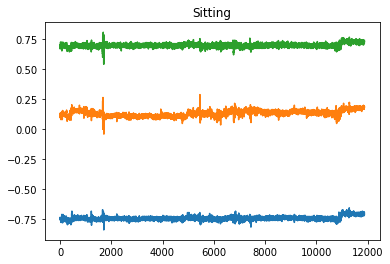

Data from Gyroscope


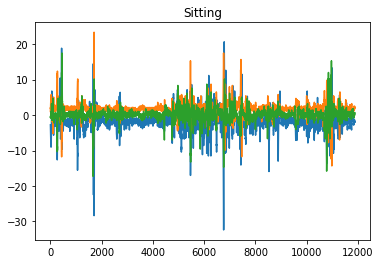

Data from Accelerometer


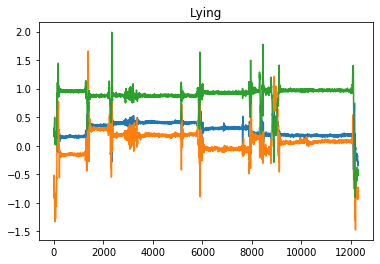

Data from Gyroscope


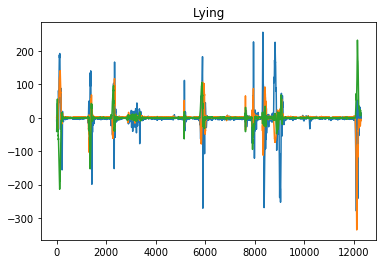

Data from Accelerometer


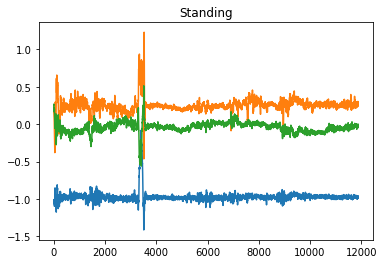

Data from Gyroscope


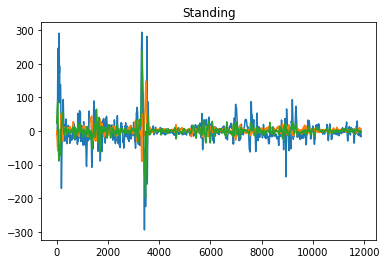

Data from Accelerometer


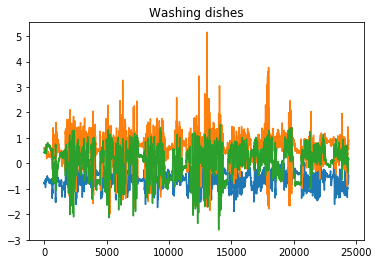

Data from Gyroscope


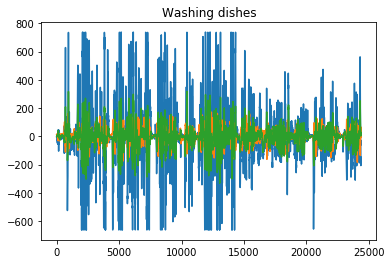

Data from Accelerometer


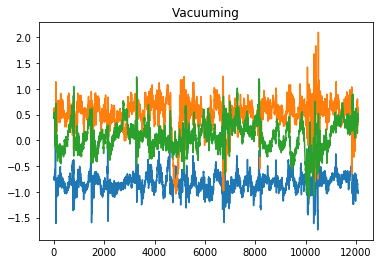

Data from Gyroscope


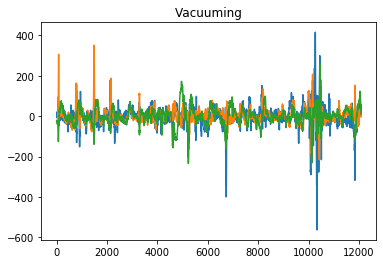

Data from Accelerometer


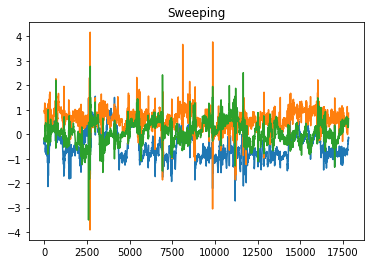

Data from Gyroscope


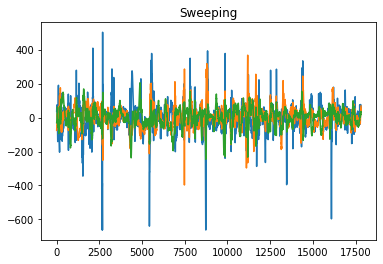

Data from Accelerometer


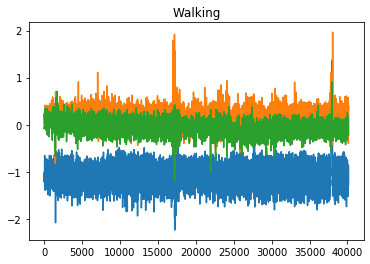

Data from Gyroscope


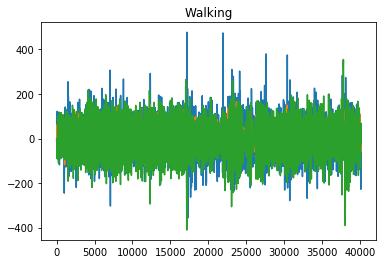

Data from Accelerometer


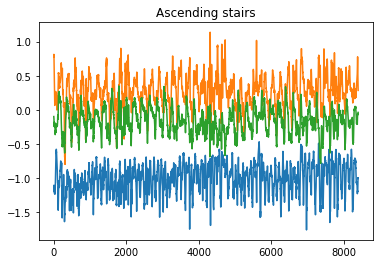

Data from Gyroscope


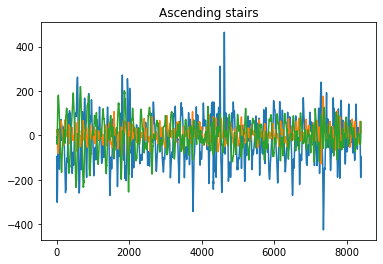

Data from Accelerometer


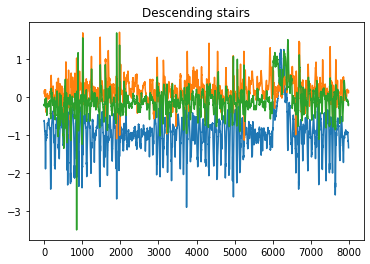

Data from Gyroscope


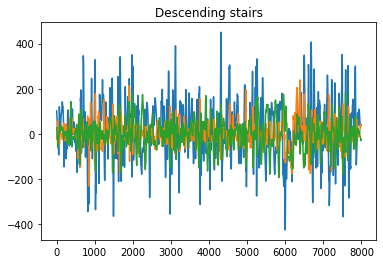

Data from Accelerometer


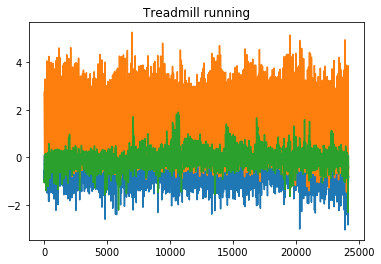

Data from Gyroscope


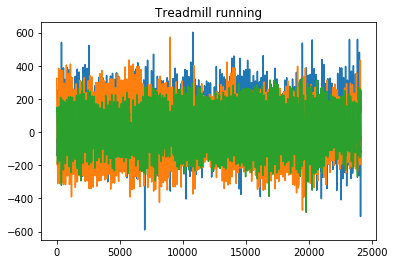

Data from Accelerometer


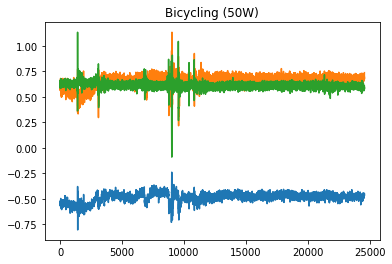

Data from Gyroscope


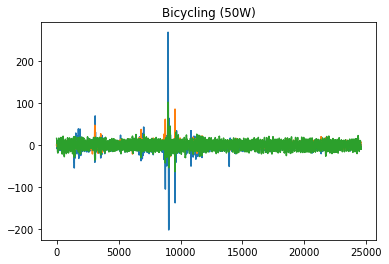

Data from Accelerometer


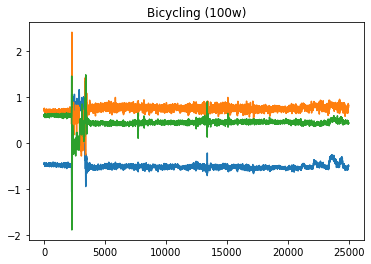

Data from Gyroscope


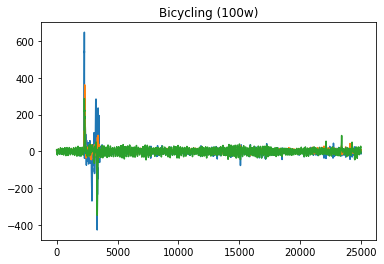

Data from Accelerometer


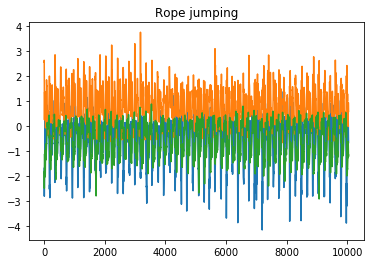

Data from Gyroscope


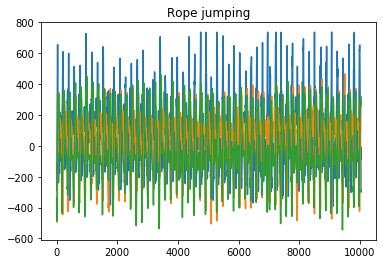

Filtered data from accelerometer


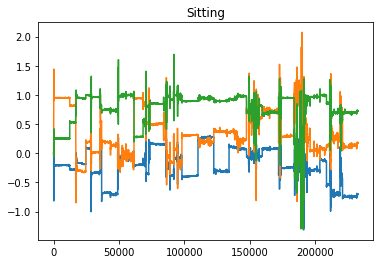

Unfiltered data from gyroscope


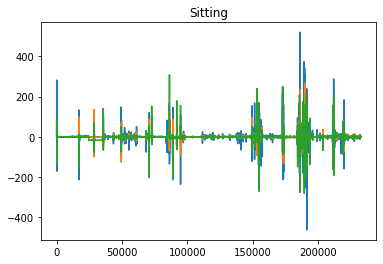

Filtered data from accelerometer


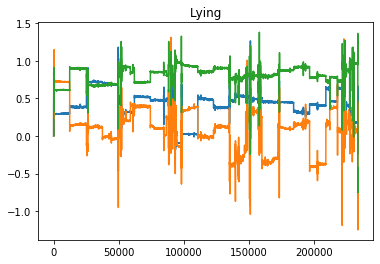

Unfiltered data from gyroscope


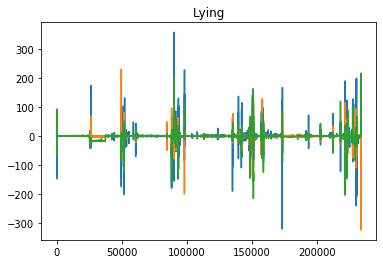

Filtered data from accelerometer


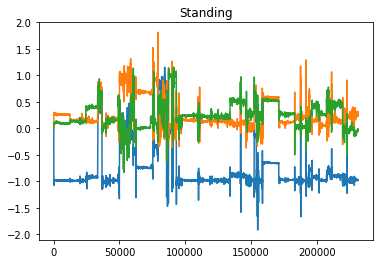

Unfiltered data from gyroscope


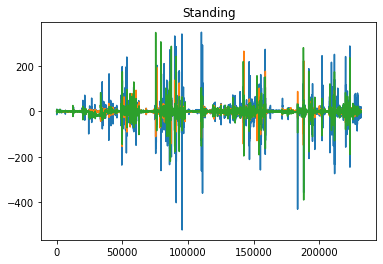

Filtered data from accelerometer


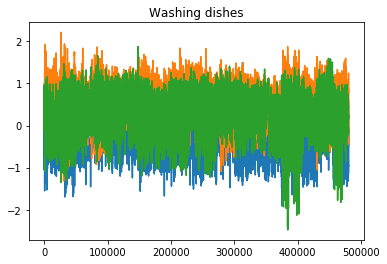

Unfiltered data from gyroscope


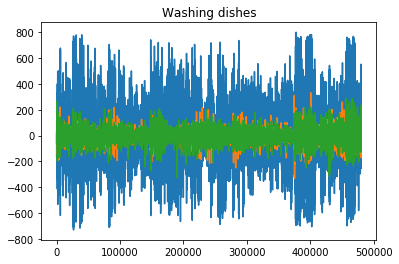

Filtered data from accelerometer


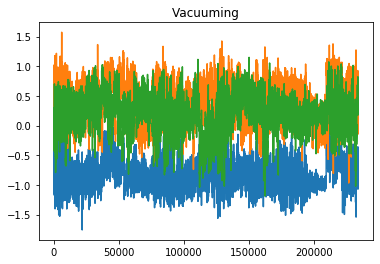

Unfiltered data from gyroscope


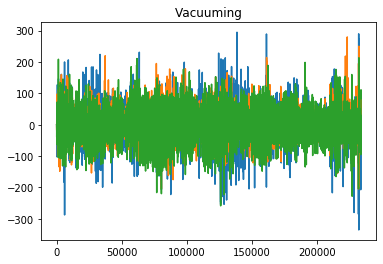

Filtered data from accelerometer


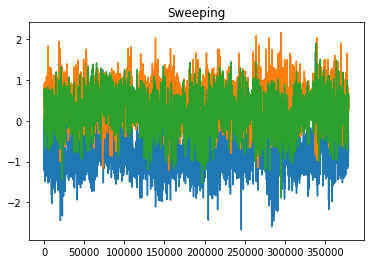

Unfiltered data from gyroscope


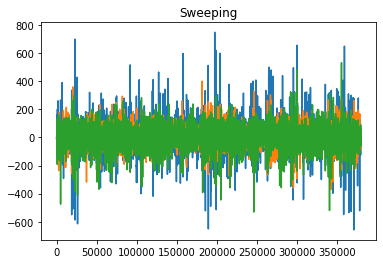

Filtered data from accelerometer


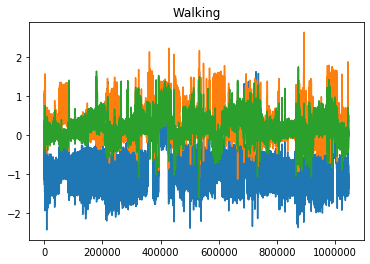

Unfiltered data from gyroscope


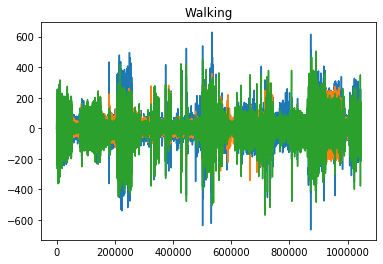

Filtered data from accelerometer


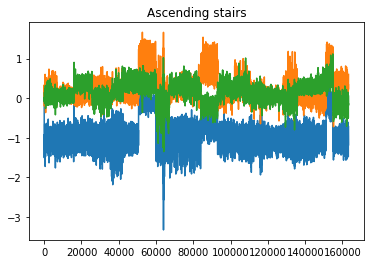

Unfiltered data from gyroscope


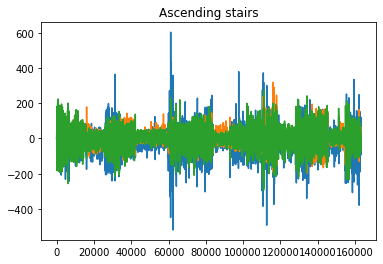

Filtered data from accelerometer


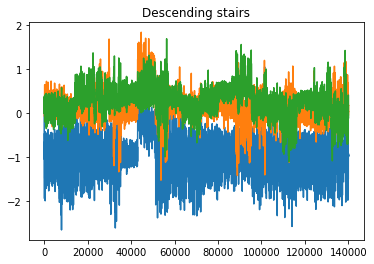

Unfiltered data from gyroscope


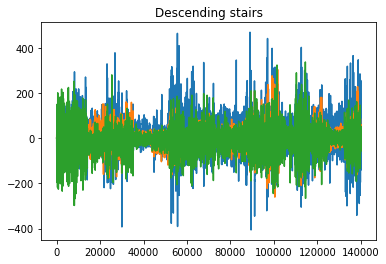

Filtered data from accelerometer


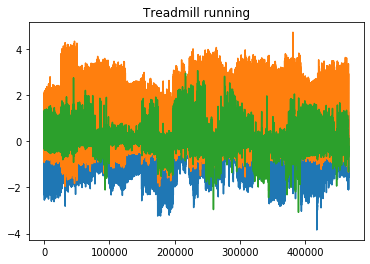

Unfiltered data from gyroscope


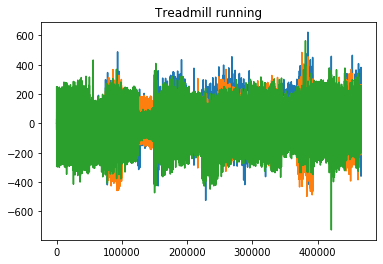

Filtered data from accelerometer


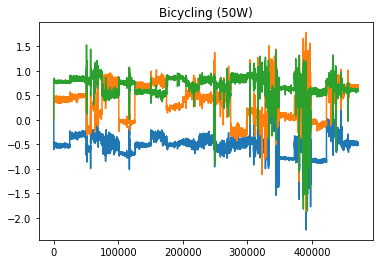

Unfiltered data from gyroscope


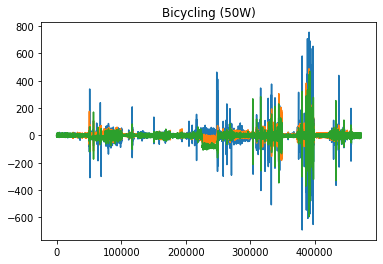

Filtered data from accelerometer


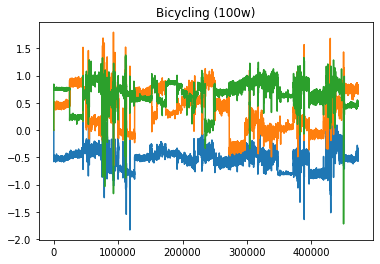

Unfiltered data from gyroscope


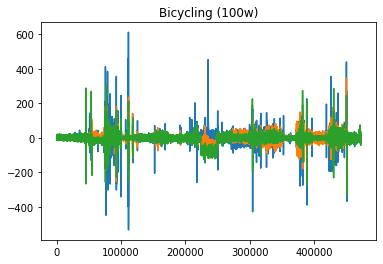

Filtered data from accelerometer


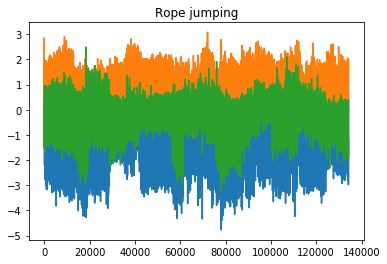

Unfiltered data from gyroscope


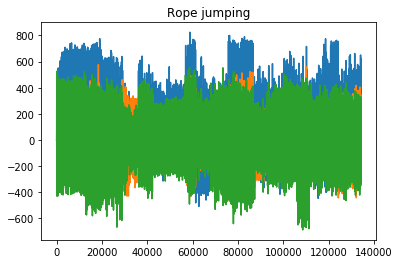

deal with dataset 1
deal with dataset 2
deal with dataset 3
deal with dataset 4
deal with dataset 5
deal with dataset 6
deal with dataset 7
deal with dataset 8
deal with dataset 9
deal with dataset 10
deal with dataset 11
deal with dataset 12
deal with dataset 13
deal with dataset 14
deal with dataset 15
deal with dataset 16
deal with dataset 17
deal with dataset 18
deal with dataset 19
Accuracy:  0.9222648752399232
[[ 57   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   1   0   0   0   0   0   0   0   0   0]
 [  0   0   2  96   1   0   0   0   0   0   0   0   0]
 [  0   0   1   1  47   5   1   1   1   0   0   0   0]
 [  0   0   0   1  16  67   0   1   0   0   0   0   0]
 [  0   0   2   0   3   1 211   1   0   0   1   0   0]
 [  0   0   1   0   0   0   2  35   0   0   0   1   0]
 [  0   0   0   0   0   1   2   0  35   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1  95   0   0   0]
 [  0   0   0   0   0   1   0 

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best clf: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.9309021113243762
[[ 57   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1  96   1   1   0   0   0   0   0   0   0]
 [  0   0   1   1  47   8   0   0   0   0   0   0   0]
 [  0   0   0   1   7  77   0   0   0   0   0   0   0]
 [  0   0   2   0   3   4 210   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0  37   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0  36   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0  95   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0  84  13   0]
 [  0   0   0   0   0   2   0   0   0   0  17  81   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0  36]]


In [112]:


if __name__ == '__main__':
    
        data_visulization()
        noise_removing()
        feature_engineering_example()
        model_training_and_evaluation_example()